# <font color="Gray">Apprentissage statistique</font>

<p>Baptiste Martinez, le 4 février 2018</p>

## <font color="Gray">TP 2 - Kernel Methods</font>

Dans ce TP, nous testons pour la première fois l'algorithme utilisant la méthode SVM (Support Vector Machine) en utilisant la bibliothèque des nombres écrits à la main (i.e. *hands-written digits*). Nous vérifierons les résultats à l'aide d'une validation croisée.

### Partie 1: Préparation


Import des bibliothèques

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC,SVR
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.svm.libsvm import decision_function

Chargement de la base usps et affichage de l'image n°56 (pour l'exemple).

In [13]:
def imLoading():
    uspsXapp = np.load('USPS/uspsXapp.npy')
    uspsYapp = np.load('USPS/uspsYapp.npy')
    nimg = 56
    im = uspsXapp[:,nimg]
    lab = uspsYapp[nimg]-1
    plt.axis('off')
    plt.imshow(np.reshape(im,(16,16)))
    plt.title('Training: %i' %lab) #affiche l'entier lab
    plt.show()

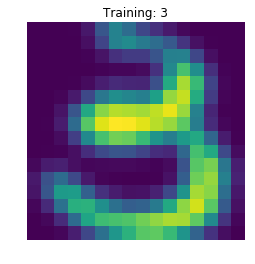

In [14]:
imLoading()

Affichage de plusieurs images en les sélectionnant aléatoirement.

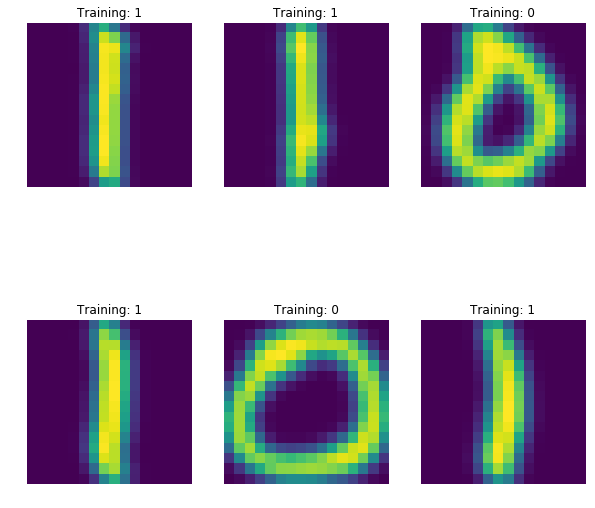

In [54]:
uspsXapp = np.load('USPS/uspsXapp.npy')
uspsYapp = np.load('USPS/uspsYapp.npy')
plt.figure(figsize=[10,10])
for iter in range(6):
    #tirage aléatoire d'une image parmi les 7291
    nimg = np.random.randint(0,7290)
    im = uspsXapp[:,nimg]
    lab = uspsYapp[nimg]-1
    plt.subplot(2,3,iter+1)
    plt.axis('off')
    plt.imshow(np.reshape(im,(16,16)))
    plt.title('Training: %i' %lab) #affiche l'entier lab
plt.show()

### Partie 2: SVR, Support Vector Regression

Construction de la base de données par la création d'une matrice de dimension deux fois le nombre de pixels pour contenir les couples de coordonnées.

In [65]:
[x1,x2]=np.meshgrid(range(16),range(16))
trainvecT = np.transpose(np.concatenate((np.reshape(x1,(1,16*16)),np.reshape(x2,(1,16*16))),axis=0))
trainlabT = im

<p>Découpage de la base en un ensemble d'apprentissage et un ensemble de test, nous déclarons la variable *prop* pour définir la proportion d'images inclus dans le jeu de test. Le jeu de données est découpé aléatoirement par la méthode *ShuffleSplit* de la bibliothèque sklearn.model_selection.</p>
<p>On utilise la méthode *ravel* afin d'obtenir d'une liste de listes, une seule liste. Pour rappel, nous avons besoin d'utiliser une régression du type *rbf* car la répartition des points (leurs classes) ne sont pas linéaires. Donc, découper l'espace à l'aide d'une base engendrant des droites ne serait pas possible.</p>

In [139]:
def test_rbf(prop):
    n_splits = 7
    plt.figure(figsize=[18,18])
    plt.subplots_adjust(hspace = 0.7)
    lpo = ShuffleSplit(n_splits=n_splits,test_size=prop)
    i = 1

    #lpo.split() returns indices to split data into training and test set
    for train_index, test_index in lpo.split(trainvecT): 
        nimg = np.random.randint(2000, size=1)
        trainlabT = uspsXapp[:,nimg]
        lab = uspsYapp[nimg]-1

        ax1 = plt.subplot(n_splits,3,i)
        i += 1
        plt.axis('off')
        ax1.imshow(np.reshape(trainlabT,(16,16)))
        plt.title('Training - This is a %i' %lab)

        Xtrain, Xtest = trainvecT[train_index], trainvecT[test_index]
        Ytrain, Ytest = trainlabT[train_index], trainlabT[test_index]

        imgReconstruite = trainlabT*0.0
        imgDegradee = trainlabT*0.0-1.0
        imgDegradee[train_index] = Ytrain

        plt.subplot(n_splits,3,i)
        plt.axis('off')
        plt.title('Damaged image: %.2f %% of pixels left' %((1-prop)*100))
        i += 1
        plt.imshow(np.reshape(imgDegradee,(16,16)))

        rbf = SVR(kernel='rbf', gamma=0.1, C=1).fit(Xtrain, np.ravel(Ytrain)) 
        imgReconstruite = rbf.predict(trainvecT)
        plt.subplot(n_splits,3,i)
        plt.title('Score: %.3f' %rbf.score(Xtest,Ytest))
        plt.axis('off')
        i += 1
        plt.imshow(np.reshape(imgReconstruite,(16,16)))
    plt.show()

Testons cette fonction avec seulement 20% de pixels sur l'image. 

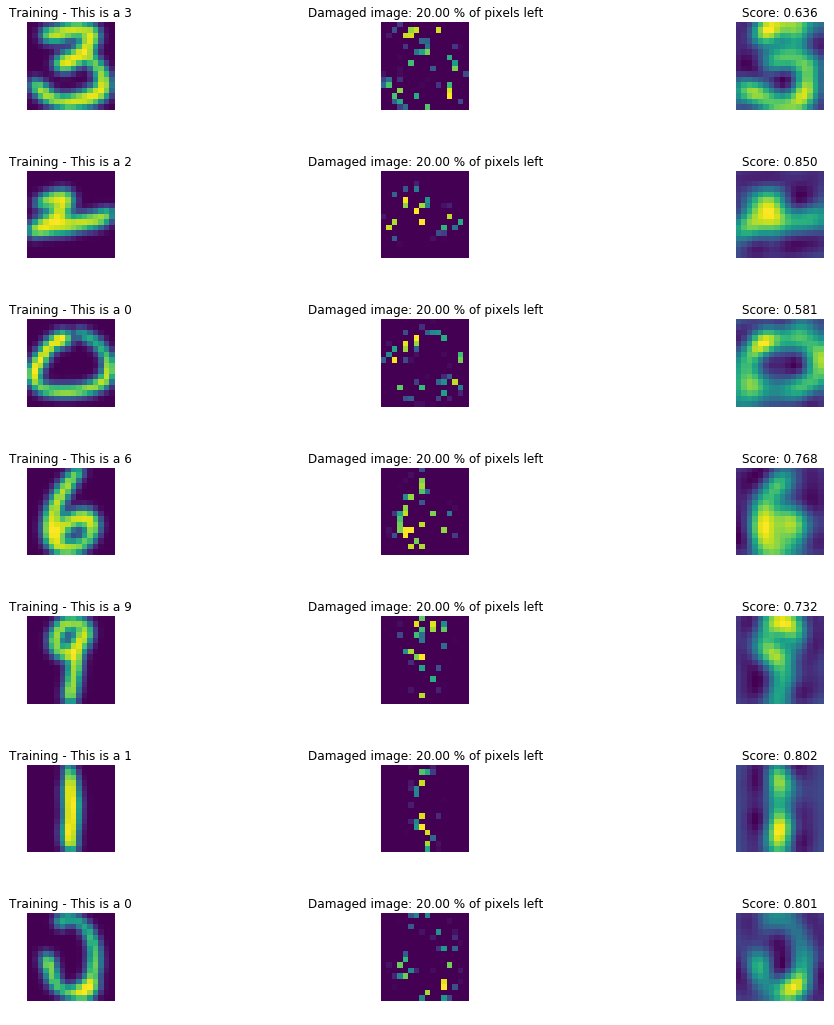

In [134]:
test_rbf(0.8)

De même, mais avec 30% puis avec 50% de pixels non dégradés.

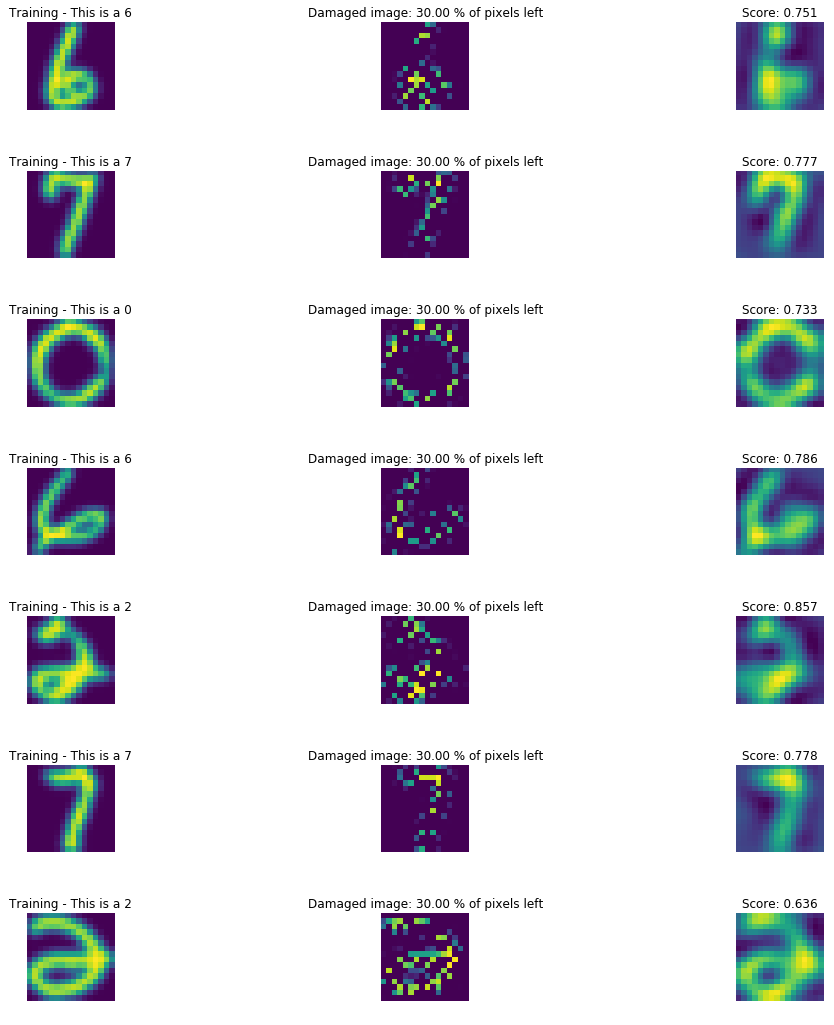

In [136]:
test_rbf(0.7)

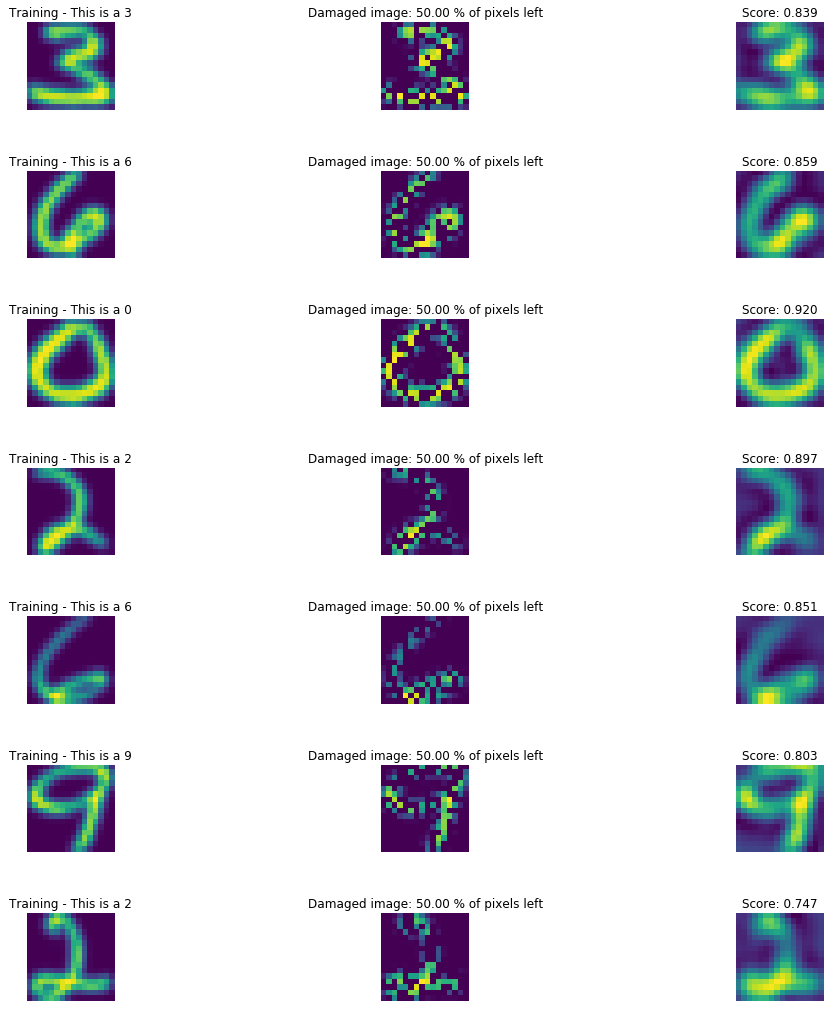

In [137]:
test_rbf(0.5)

**Bilan :**
<br>
Nous constatons avec même avec seulement 30% des images placées dans l'ensemble d'apprentissage, nous obtenons des scores se situant autour des 0.75, cela signifie que 75% des prédictions réalisées par l'algorithme sont corrects.
<br>Néanmoins, avec 20% de pixels non dégradés, les scores varient très facilement. Les scores les plus faibles sont obtenus si la forme est complexe (i.e. très différente d'une forme régulière comme une droite ou un cercle) et si le tirage des pixels restants ne suit pas du tout la forme véritable du chiffre. Dans ce cas, la régression s'effectue difficilement.<br>Si nous souhaitons un score moyen qui se situe plutôt autour des 0.8 (80% de prédictions correctes), il faut laisser à l'algorithme environ la moitié de l'ensemble des images de la base usps.

### Mise en place de la validation croisée

Pour effectuer la validation croisée, nous allons utiliser la méthode *cross_val_score* de la bibliothèque *sklearn.model_selection*. Pour cela, implémentons de nouveau la fonction *test_rbf* en y ajoutant la validation croisée. Nommons cette nouvelle fonction *test_rbfCV*.
<br>
<font color="red">Remarque:</font> MSE = Mean Squared Error ≡ Précision<br>
<font color="red">Remarque 2:</font> j'ai testé le deuxième formalisme d'affichage de variables que je ne connaissais pas, à l'aide de *.format* et non de *%*. Il me paraît beaucoup plus pratique à utiliser.

In [166]:
def test_rbfCV(prop):
    n_splits = 7
    plt.figure(figsize=[18,18])
    plt.subplots_adjust(hspace = 0.7)
    lpo = ShuffleSplit(n_splits=n_splits,test_size=prop)
    i = 1

    #lpo.split() returns indices to split data into training and test set
    for train_index, test_index in lpo.split(trainvecT): 
        nimg = np.random.randint(2000, size=1)
        trainlabT = uspsXapp[:,nimg]
        lab = uspsYapp[nimg]-1

        ax1 = plt.subplot(n_splits,3,i)
        i += 1
        plt.axis('off')
        ax1.imshow(np.reshape(trainlabT,(16,16)))
        plt.title('Training - This is a %i' %lab)

        Xtrain, Xtest = trainvecT[train_index], trainvecT[test_index]
        Ytrain, Ytest = trainlabT[train_index], trainlabT[test_index]

        imgReconstruite = trainlabT*0.0
        imgDegradee = trainlabT*0.0-1.0
        imgDegradee[train_index] = Ytrain

        plt.subplot(n_splits,3,i)
        plt.axis('off')
        plt.title('Damaged image: %.2f %% of pixels left' %((1-prop)*100))
        i += 1
        plt.imshow(np.reshape(imgDegradee,(16,16)))

        rbf = SVR(kernel='rbf', gamma=0.1, C=1).fit(Xtrain, np.ravel(Ytrain)) 
        imgReconstruite = rbf.predict(trainvecT)
        plt.subplot(n_splits,3,i)
        scores = cross_val_score(rbf, Xtest, np.ravel(Ytest), cv=lpo,n_jobs=1)
        # scores.std() retourne l'écart-type du calcul de l'erreur
        plt.title('Score = {:.2f}\nMSE = {:.2f}(+/- {:.2f})' .format(rbf.score(Xtest,Ytest),-scores.mean(), scores.std()))
        plt.axis('off')
        i += 1
        plt.imshow(np.reshape(imgReconstruite,(16,16)))
    plt.show()

Test de l'utilisation de la validation croisée avec 30% des images en apprentissage

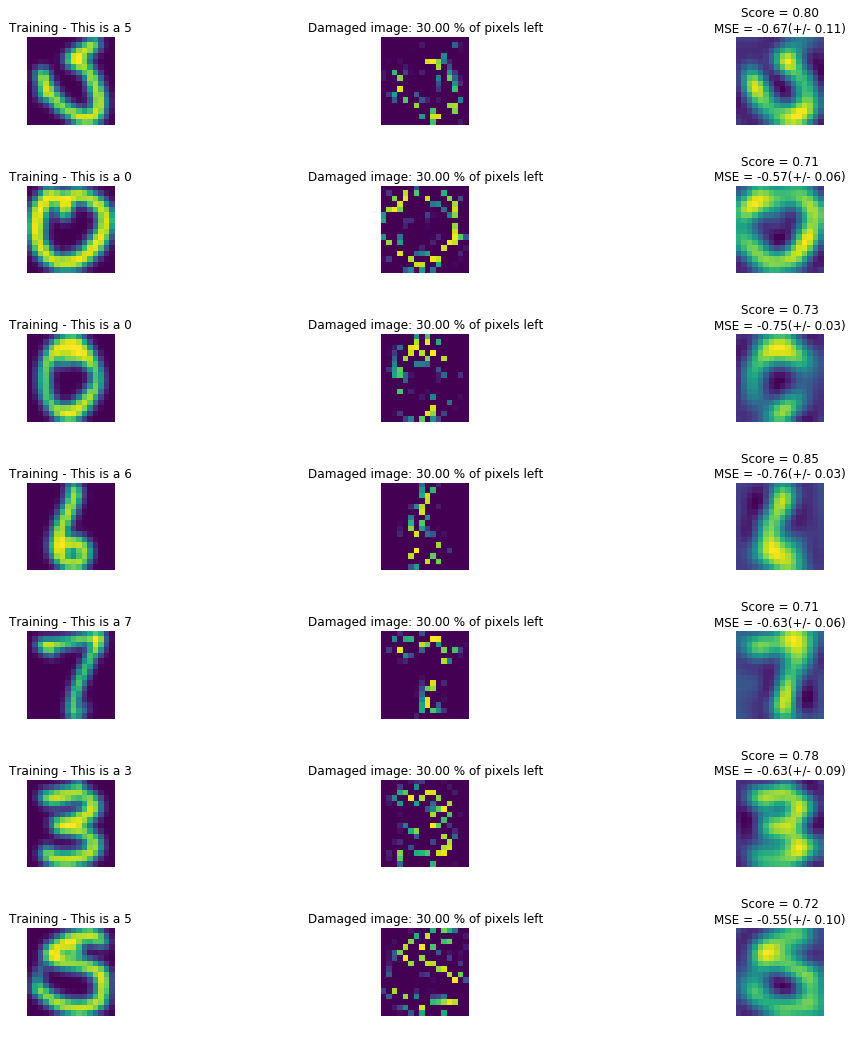

In [167]:
test_rbfCV(0.7)

Mettons en place une fonction retournant le meilleur triplet des paramètres *C* et *gamma* de la fonction *SVR*, avec *gamma* = 1/ε

In [256]:
def test_rbfCV(prop):
    n_splits = 7
    
    # configuration de la grille d'affichage complète
#     plt.figure(figsize=[18,18])
#     plt.subplots_adjust(hspace = 0.7)
    # découpage de la base en set de test et set d'apprentissage
    lpo = ShuffleSplit(n_splits=n_splits,test_size=prop)
    param_gam = np.arange(0,10,0.2)
    param_c = np.arange(1,1000,10)
    maxScore = 0.0
    gammaOpti = []
    maxScoreList = []
    cOpti = []
    #lpo.split() returns indices to split data into training and test set
    for gamma,C in zip(param_gam,param_c):
        
        for train_index, test_index in lpo.split(trainvecT):

            # choix de l'image arbitraire, nous souhaitons simplement fixer le numéro 
            # afin de  pouvoir conclure sur les résultats obtenus
            nimg = 4250 
            trainlabT = uspsXapp[:,nimg]
            lab = uspsYapp[nimg]-1

    #         # configuration de la grille d'affichage courante
    #         ax1 = plt.subplot(1,3,1)
    #         plt.axis('off')
    #         ax1.imshow(np.reshape(trainlabT,(16,16)))
    #         plt.title('Training - This is a %i' %lab)

            Xtrain, Xtest = trainvecT[train_index], trainvecT[test_index]
            Ytrain, Ytest = trainlabT[train_index], trainlabT[test_index]

            imgReconstruite = trainlabT*0.0
            imgDegradee = trainlabT*0.0-1.0
            imgDegradee[train_index] = Ytrain

    #         # configuration de la grille d'affichage courante
    #         plt.subplot(1,3,2)
    #         plt.axis('off')
    #         plt.title('Damaged image: %.2f %% of pixels left' %((1-prop)*100))
    #         plt.imshow(np.reshape(imgDegradee,(16,16)))

            rbf = SVR(kernel='rbf', gamma=0.1, C=1).fit(Xtrain, np.ravel(Ytrain)) 
            scoreCour = rbf.score(Xtest,Ytest)
            imgReconstruite = rbf.predict(trainvecT)

    #         # configuration de la grille d'affichage courante
    #         plt.subplot(1,3,3)

    #         # validation croisée
#             scores = cross_val_score(rbf, Xtest, np.ravel(Ytest), cv=lpo,n_jobs=1)
            if maxScore < scoreCour:
                maxScoreList.append(scoreCour)
                cOpti.append(C)
                gammaOpti.append(gamma)
            if maxScore < scoreCour:
                maxScore = scoreCour
                Copti = C
                GammaOpti = gamma
    #         # scores.std() retourne l'écart-type du calcul de l'erreur
    #         plt.title('Score = {:.2f}\nMSE = {:.2f}(+/- {:.2f})' .format(rbf.score(Xtest,Ytest),-scores.mean(), scores.std()))
    #         plt.axis('off')
    #         i += 1
    #         plt.imshow(np.reshape(imgReconstruite,(16,16)))
    #     plt.show()
    print("Parmi les scores maximaux relevés sur l'image n°{:d}, C est égale en moyenne à {:.1f} et gamma à {:1f}\nen ayant obtenu un score moyen égale à {:.2f}.\n".format(nimg,np.mean(cOpti), np.mean(gammaOpti), np.mean(maxScoreList))) 
    print("La valeur de C optimal vaut {:.1f} et gamma optimal vaut: {:.1f} en ayant obtenu un score égale à {:.2f}.".format(Copti, GammaOpti, maxScore)) 

In [257]:
test_rbfCV(0.7)

Parmi les scores maximaux relevés sur l'image n°4250, C est égale en moyenne à 71.0 et gamma à 1.400000
en ayant obtenu un score moyen égale à 0.76.

La valeur de C optimal vaut 241.0 et gamma optimal vaut: 4.8 en ayant obtenu un score égale à 0.83.
